In [1]:
import d2lzh as d2l
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, nn
import time

net = nn.Sequential()
net.add(nn.Conv2D(channels=12, kernel_size=5, activation='sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=32, kernel_size=5, activation='sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        # Dense会默认将(批量大小, 通道, 高, 宽)形状的输入转换成
        # (批量大小, 通道 * 高 * 宽)形状的输入
        nn.Dense(240, activation='sigmoid'),
        nn.Dense(168, activation='sigmoid'),
        nn.Dense(10))

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [3]:
def try_gpu():  # 本函数已保存在d2lzh包中方便以后使用
    try:
        ctx = mx.gpu()
        _ = nd.zeros((1,), ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx

ctx = try_gpu()
ctx

gpu(0)

In [4]:
# 本函数已保存在d2lzh包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中
# 描述
def evaluate_accuracy(data_iter, net, ctx):
    acc_sum, n = nd.array([0], ctx=ctx), 0
    for X, y in data_iter:
        # 如果ctx代表GPU及相应的显存，将数据复制到显存上
        X, y = X.as_in_context(ctx), y.as_in_context(ctx).astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.size
    return acc_sum.asscalar() / n

In [5]:
# 本函数已保存在d2lzh包中方便以后使用
def train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx,
              num_epochs):
    print('training on', ctx)
    loss = gloss.SoftmaxCrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [190]:
lr, num_epochs = 0.9, 5
net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs)

training on gpu(0)
epoch 1, loss 2.3354, train acc 0.101, test acc 0.100, time 10.8 sec
epoch 2, loss 2.3036, train acc 0.101, test acc 0.102, time 10.2 sec
epoch 3, loss 2.0940, train acc 0.188, test acc 0.566, time 10.4 sec
epoch 4, loss 0.9876, train acc 0.600, test acc 0.689, time 11.8 sec
epoch 5, loss 0.7611, train acc 0.698, test acc 0.720, time 11.2 sec


In [184]:
lr, num_epochs = 0.9, 5
net.initialize(force_reinit=True, ctx=ctx, init=init.Normal(sigma=0.01))#合适的初始化对于学习速度的影响很大
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs)

training on gpu(0)
epoch 1, loss 2.3257, train acc 0.099, test acc 0.100, time 10.3 sec
epoch 2, loss 2.3038, train acc 0.102, test acc 0.100, time 11.4 sec
epoch 3, loss 2.3036, train acc 0.101, test acc 0.100, time 9.9 sec
epoch 4, loss 2.3035, train acc 0.099, test acc 0.100, time 10.1 sec
epoch 5, loss 2.3037, train acc 0.097, test acc 0.100, time 12.1 sec


In [49]:
lr, num_epochs = 0.9, 50
net.initialize(force_reinit=True, ctx=ctx, init=init.Normal(sigma=0.5))#合适的初始化对于学习速度的影响很大
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs)

training on gpu(0)
epoch 1, loss 1.8561, train acc 0.377, test acc 0.673, time 9.1 sec
epoch 2, loss 0.7575, train acc 0.704, test acc 0.748, time 8.4 sec
epoch 3, loss 0.6311, train acc 0.754, test acc 0.786, time 11.8 sec
epoch 4, loss 0.5623, train acc 0.783, test acc 0.818, time 13.1 sec
epoch 5, loss 0.5084, train acc 0.807, test acc 0.834, time 12.6 sec
epoch 6, loss 0.4748, train acc 0.822, test acc 0.843, time 10.0 sec
epoch 7, loss 0.4458, train acc 0.835, test acc 0.859, time 9.9 sec
epoch 8, loss 0.4211, train acc 0.844, test acc 0.859, time 9.8 sec
epoch 9, loss 0.4030, train acc 0.851, test acc 0.859, time 10.5 sec
epoch 10, loss 0.3887, train acc 0.856, test acc 0.860, time 10.7 sec
epoch 11, loss 0.3807, train acc 0.859, test acc 0.856, time 9.7 sec
epoch 12, loss 0.3679, train acc 0.863, test acc 0.865, time 9.9 sec
epoch 13, loss 0.3565, train acc 0.868, test acc 0.874, time 9.8 sec
epoch 14, loss 0.3524, train acc 0.869, test acc 0.871, time 9.8 sec
epoch 15, loss 0.3

In [203]:
lr, num_epochs = 0.9, 50
net.initialize(force_reinit=True, ctx=ctx, init=init.Normal(sigma=0.18))#合适的初始化对于学习速度的影响很大
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs)

training on gpu(0)
epoch 1, loss 1.7528, train acc 0.369, test acc 0.700, time 10.4 sec
epoch 2, loss 0.7369, train acc 0.713, test acc 0.767, time 11.3 sec
epoch 3, loss 0.5898, train acc 0.770, test acc 0.787, time 13.1 sec
epoch 4, loss 0.5138, train acc 0.802, test acc 0.823, time 12.1 sec
epoch 5, loss 0.4617, train acc 0.827, test acc 0.853, time 11.7 sec
epoch 6, loss 0.4224, train acc 0.844, test acc 0.851, time 12.4 sec
epoch 7, loss 0.3971, train acc 0.852, test acc 0.864, time 13.2 sec
epoch 8, loss 0.3783, train acc 0.860, test acc 0.863, time 12.2 sec
epoch 9, loss 0.3603, train acc 0.865, test acc 0.866, time 12.2 sec
epoch 10, loss 0.3499, train acc 0.870, test acc 0.877, time 12.5 sec
epoch 11, loss 0.3376, train acc 0.874, test acc 0.874, time 12.3 sec
epoch 12, loss 0.3258, train acc 0.879, test acc 0.878, time 12.0 sec
epoch 13, loss 0.3167, train acc 0.883, test acc 0.883, time 12.7 sec
epoch 14, loss 0.3086, train acc 0.885, test acc 0.887, time 13.3 sec
epoch 15, 

In [172]:
#输入卷积格式的图形
def extract_features(X, layers,ctx = ctx):
    X = X.copyto(ctx)
    imgs = []
    for i in range(len(net)):
        X = net[i](X)
        if i in layers:
            imgs.append(X)
    return imgs

In [187]:
for X, y in test_iter:
    break

In [204]:
layers = [0,1,2,3]
imgs_X = extract_features(X, layers)
d2l.use_svg_display()

In [195]:
# d2l.plt.imshow(X[id].squeeze().asnumpy())#可显示单色（2维），彩色（3维）
def showlayers(id):
    _, figs = d2l.plt.subplots(1, 1, figsize=(2, 2))
    figs.imshow(X[id][0].asnumpy())
    figs.set_title(d2l.get_fashion_mnist_labels(y[id].asnumpy())[0])
    figs.axes.get_xaxis().set_visible(False)
    figs.axes.get_yaxis().set_visible(False)

    for imgs in imgs_X:
    # 这里的_表示我们忽略（不使用）的变量
        _, figs = d2l.plt.subplots(1, imgs.shape[1], figsize=(16, 16))
        for f, img in zip(figs, imgs[id]):
            f.imshow(img.asnumpy())
            f.axes.get_xaxis().set_visible(False)
            f.axes.get_yaxis().set_visible(False)

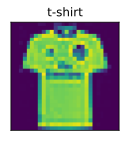

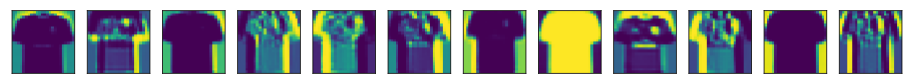

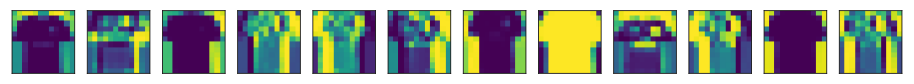

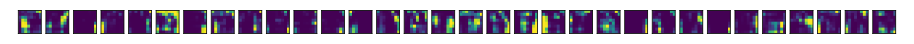

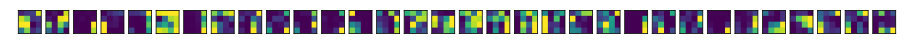

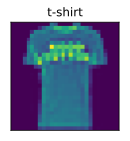

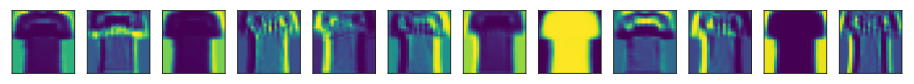

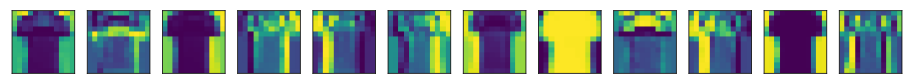

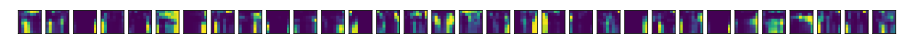

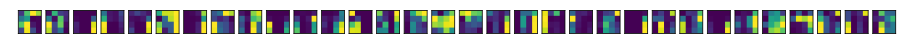

In [205]:
for i in [0,9]:
    showlayers(i)

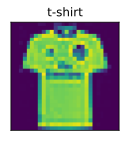

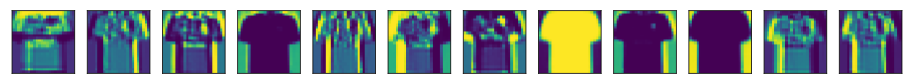

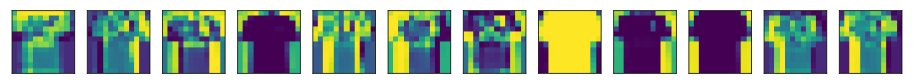

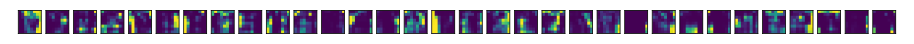

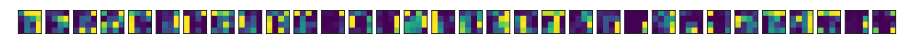

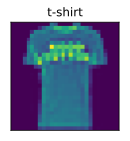

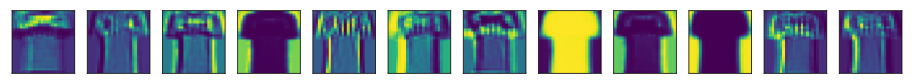

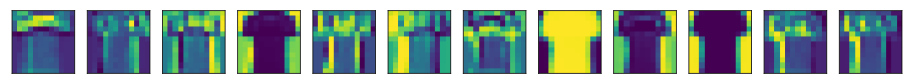

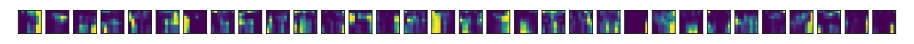

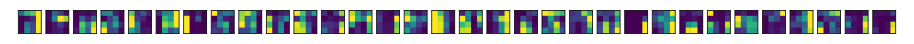

In [202]:
for i in [0,9]:
    showlayers(i)

图像在进入卷积网络之前首先要将数据格式转换为卷积神经网络接受的输入格式。通道数不限，像素的浮点数值在0到1之间，维度为：通道，高，宽
对于1通道的图像如Fashion_MNIST,可使用transformer = gdata.vision.transforms.ToTensor()
对于3通道的图像，定义图像的预处理函数和后处理函数。预处理函数preprocess对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式。后处理函数postprocess则将输出图像中的像素值还原回标准化之前的值。由于图像打印函数要求每个像素的浮点数值在0到1之间，我们使用clip函数对小于0和大于1的值分别取0和1。

rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

#image_shape = (450, 300)#高和宽分别为300和450像素，此处的形状的表示和卷积中不同，需注意

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)#输出为高，宽，通道
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return img.transpose((2, 0, 1)).expand_dims(axis=0)#将通道调整成卷积格式

def postprocess(img):
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1, 2, 0)) * rgb_std + rgb_mean).clip(0, 1)#将通道还原成图像格式

conv_layers, pool_layers = [0, 2], [1, 3]
convs_X, pools_X, c_labels_X, p_labels_X = extract_features(X, conv_layers, pool_layers)

# 本函数已保存在d2lzh包中方便以后使用
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = d2l.plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        
img = image.imread('../img/catdog.jpg')
X = img.astype('float32').transpose((2, 0, 1)).expand_dims(axis=0) / 255
Y = conv_trans(X)
out_img = Y[0].transpose((1, 2, 0))

d2l.set_figsize()
print('input image shape:', img.shape)
d2l.plt.imshow(img.asnumpy());
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img.asnumpy());

X, y = mnist_train[0:9]
show_fashion_mnist(X, get_fashion_mnist_labels(y))